In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## Escapes Prediction

In [21]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Display the first few rows of the dataframe
#print(data.head())

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Comments', 'Nb Hatch escapes'])
target = data['Nb Escaped Survivors']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0].values.reshape(1, -1)
predicted_escapes = model.predict(example)
print(example)
print(f'Predicted number of survivors escaping: {predicted_escapes[0]}')

# Save the model
import joblib
joblib.dump(model, 'dbd_survivor_prediction_model.pkl')

Mean Squared Error: 1.151145123927233
R^2 Score: 0.3950789889174279
[[4 21 3 7 False]]
Predicted number of survivors escaping: 0.34666666666666673


['dbd_survivor_prediction_model.pkl']

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import joblib

Mean Squared Error: 1.2065972222222223
R^2 Score: 0.3659391883223333
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping for this round: 0.0
Actual number of survivors escaping for this round: 1


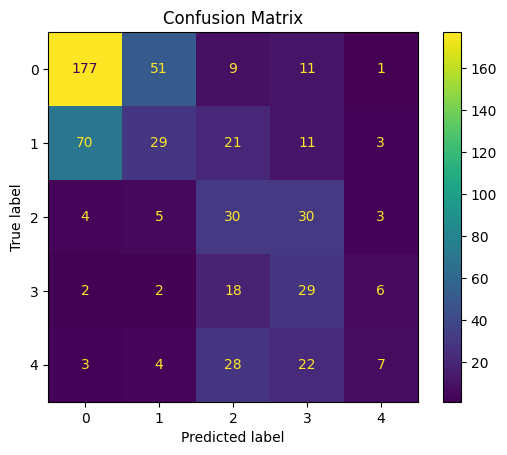

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       249
           1       0.32      0.22      0.26       134
           2       0.28      0.42      0.34        72
           3       0.28      0.51      0.36        57
           4       0.35      0.11      0.17        64

    accuracy                           0.47       576
   macro avg       0.38      0.39      0.37       576
weighted avg       0.48      0.47      0.46       576



['dbd_survivor_prediction_model_2.pkl']

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Comments', 'Nb Hatch escapes', 'SBMM', 'Season'])
target = data['Nb Escaped Survivors']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test).round().clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_escapees = model.predict(example).round().clip(0, 4)
actual_escapees = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping for this round: {predicted_escapees[0]}')
print(f'Actual number of survivors escaping for this round: {actual_escapees}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(model, 'dbd_survivor_prediction_model_2.pkl')
